In [23]:
import numpy as np
import os
from PIL import Image
import random
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import tensorflow as tf
import matplotlib.image as img
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

dataset_path = './archive/Shoe vs Sandal vs Boot Dataset'

images = []
labels = []

for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    image_filenames = os.listdir(subfolder_path)
    random.shuffle(image_filenames) #датасет изначально был отсортирован по папкам - класстерам)

    for image_filename in image_filenames:
        image_path = os.path.join(subfolder_path, image_filename)
        img = Image.open(image_path).convert('L') # конвертация изображения в серый
        # https://pillow.readthedocs.io/en/stable/reference/Image.html
        img = img.resize((75, 75)) # стандартизация размеров
        img_array = np.array(img) / 255.0 # нормализация цветов
        images.append(img_array)
        labels.append(subfolder) # label-ом будет являться подпапка (датасет изначально был отсортирован по папкам - класстерам)

df = pd.DataFrame({'image': images, 'label': labels})

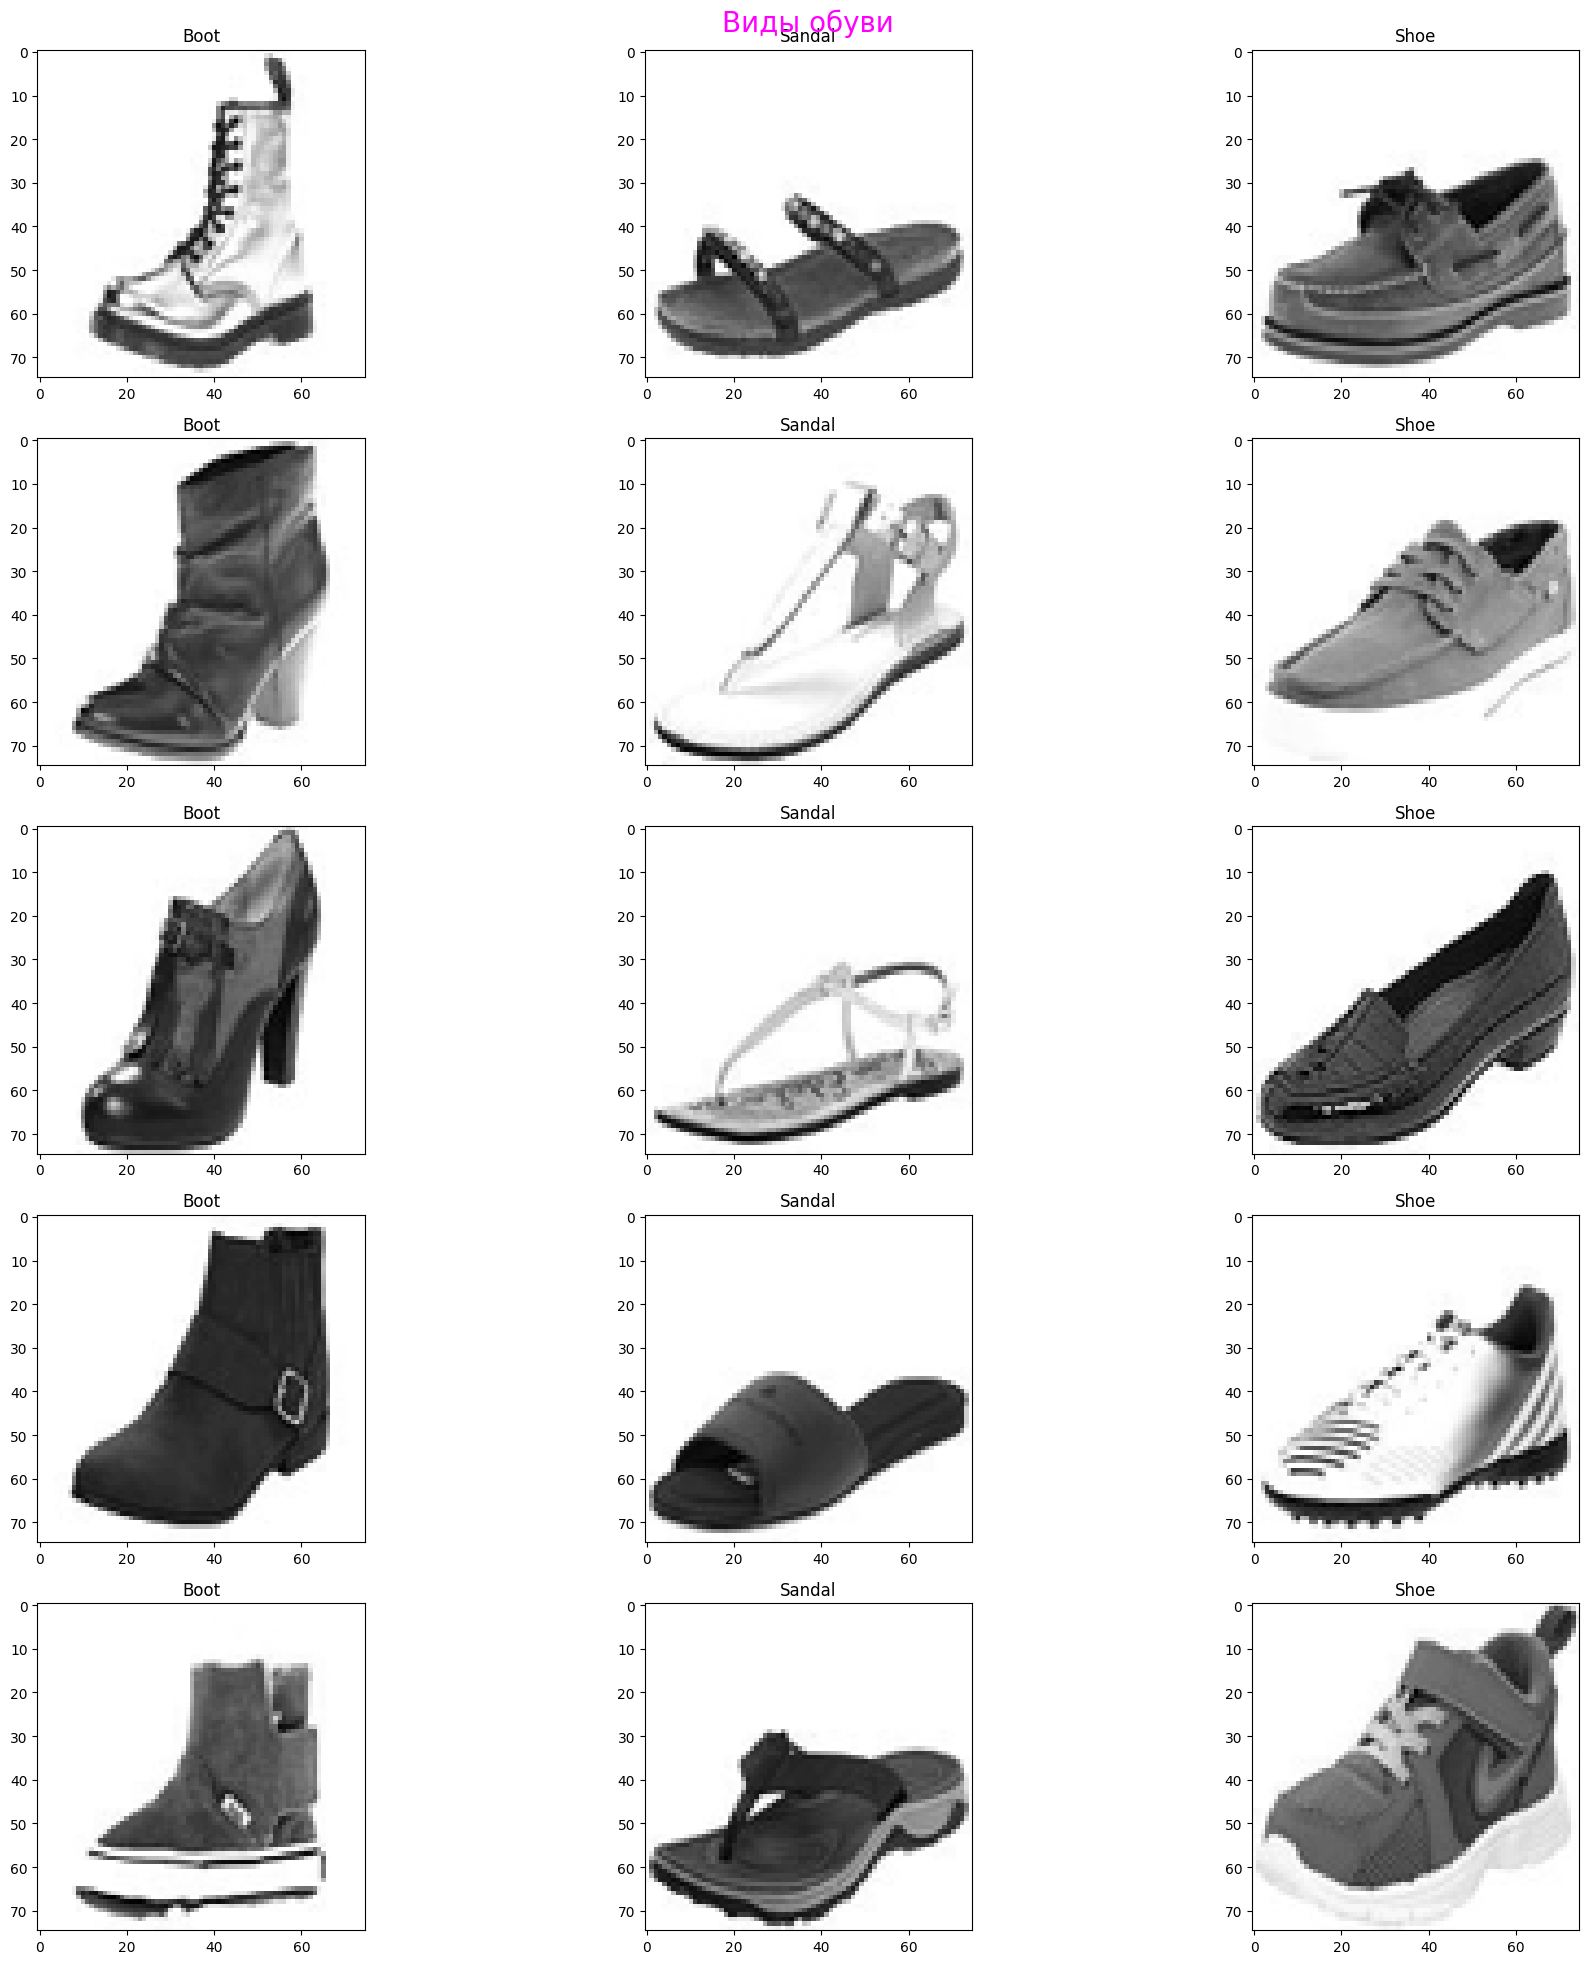

In [24]:
#Этот код строит сетку изображений, каждая строка которой содержит 
#5 изображений одного типа обуви, а каждый столбец представляет определенный тип обуви.
fig, ax = plt.subplots(nrows=5, #
                       ncols=len(df['label'].unique()), #количеством столбцов (количество уникальных меток в столбце 'label')
                       figsize=(20, 20))
fig.suptitle('Виды обуви', color='magenta', fontsize=20)

for i, (label, group) in enumerate(df.groupby('label')):
    #тот цикл for проходит по каждой уникальной метке в столбце 'label' датафрейма df, а также соответствующей группе изображений.
    for j in range(5):
        #Этот вложенный цикл for проходит по первым 5 изображениям в каждой группе.
        ax[j, i].imshow(group.iloc[j]['image'], cmap='gray') # вывод в текущую ячейку  
        ax[j, i].set_title(label)

plt.tight_layout() # Этот метод позволяет автоматически настроить отступы и распределение графиков, чтобы сделать их более читаемыми и избежать наложения.
plt.show()


In [25]:
X_train, X_test, y_train, y_test = train_test_split(df['image'],
                                                    df['label'],
                                                    test_size=0.3,
                                                    random_state=42)
# random_state=42  для разделения.
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#tolist() используется для преобразования серий Pandas в списки Python, а затем np.array() преобразует списки в массивы NumPy.
X_train = np.array(X_train.tolist())
X_test = np.array(X_test.tolist())

# Эти строки добавляют размерность к массивам изображений. 
#В данном случае это необходимо, чтобы данные соответствовали ожиданиям модели.
#axis=-1 указывает, что размерность будет добавлена в конце массива.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# LabelEncoder, который будет преобразовывать текстовые метки классов в числовые значения.
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Преобразовать целевые данные в one-hot encoding
num_classes = 3  # количество классов
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

In [26]:

# Задаем размер изображения
image_size = (75, 75)

# Задаем размер пакета (batch size)
batch_size = 32

# Создаем генератор для обучающих данных
datagen = ImageDataGenerator(rotation_range=45,  # диапазон углов поворота
                             width_shift_range=0.2,  # диапазон сдвига по ширине
                             height_shift_range=0.2,  # диапазон сдвига по высоте
                             shear_range=0.2,  # диапазон сдвига/изгиба
                             zoom_range=0.2,  # диапазон увеличения/уменьшения
                             horizontal_flip=True,  # случайное горизонтальное отражение
                             fill_mode='nearest')  # метод заполнения пикселей за границами

# Создаем поток данных для обучающих изображений
train_generator = datagen.flow(X_train,  # обучающие изображения
                               y_train_categorical,  # метки классов в формате one-hot encoding
                               batch_size=batch_size)  # размер пакета

# Создаем поток данных для тестовых изображений
test_generator = datagen.flow(X_test,  # тестовые изображения
                              y_test_categorical,  # метки классов в формате one-hot encoding
                              batch_size=batch_size)  # размер пакета

In [28]:
model = Sequential()

model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu',
                 input_shape=(75, 75, 1)))  # Поменяли input_shape на (75, 75, 1)
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128,
                 kernel_size=(3, 3),
                 padding='Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation="softmax"))  # Исправлено на num_classes

print(model.summary())


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 75, 75, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,692,355 (40.79 MB)

 Trainable params: 10,692,355 (40.79 MB)

 Non-trainable params: 0 (0.00 B)

None


In [29]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
epochs = 8

In [30]:
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/8


/home/bionic/PycharmProjects/oirs_neuralnetworks/venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 70s 209ms/step - accuracy: 0.4209 - loss: 1.2009 - val_accuracy: 0.5756 - val_loss: 0.9046
Epoch 2/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 75s 226ms/step - accuracy: 0.5548 - loss: 0.9058 - val_accuracy: 0.6449 - val_loss: 0.7775
Epoch 3/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 73s 220ms/step - accuracy: 0.6354 - loss: 0.7843 - val_accuracy: 0.6573 - val_loss: 0.7284
Epoch 4/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 70s 214ms/step - accuracy: 0.6617 - loss: 0.7511 - val_accuracy: 0.6538 - val_loss: 0.7642
Epoch 5/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 74s 223ms/step - accuracy: 0.6768 - loss: 0.7080 - val_accuracy: 0.7278 - val_loss: 0.6307
Epoch 6/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 76s 229ms/step - accuracy: 0.6941 - loss: 0.6844 - val_accuracy: 0.7478 - val_loss: 0.5966
Epoch 7/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 69s 211ms/step - accuracy: 0.7117 - loss: 0.6477 - val_accuracy: 0.7760 - val_loss: 0.5569
Epoch 8/8
329/329 ━━━━━━━━━━━━━━━━━━━━ 76s 231ms/step - accuracy: 0.7241 - loss: 0.6265 - val_accura

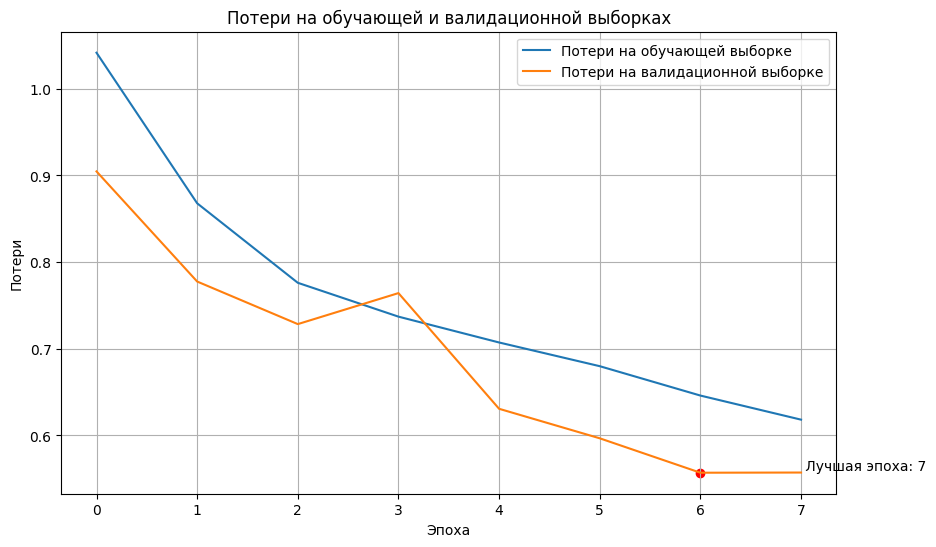

In [31]:
def plot_loss(history):
    """
    Функция для построения графика потерь для обучающей и тестовой выборок.

    Parameters:
    history: объект истории обучения модели.
    """
    # Получение значений потерь для обучающей и тестовой выборок
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Получение лучшей эпохи по val_loss
    best_epoch = np.argmin(val_loss) + 1

    # Построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Потери на обучающей выборке')
    plt.plot(val_loss, label='Потери на валидационной выборке')
    plt.title('Потери на обучающей и валидационной выборках')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    plt.xticks(range(0, len(train_loss)))

    # Отмечаем лучшую эпоху по val_loss
    plt.scatter(best_epoch - 1,
                val_loss[best_epoch - 1],
                color='red',
                label=f'Лучшая эпоха: {best_epoch}')
    plt.text(best_epoch,
             val_loss[best_epoch - 1],
             f' Лучшая эпоха: {best_epoch}',
             verticalalignment='bottom')

    plt.show()


plot_loss(history)

In [32]:
# Создать пустые списки для хранения случайно выбранных изображений и их меток
random_images = []
random_labels = []

# Проходим по каждому классу
for class_name in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, class_name)
    if not os.path.isdir(subfolder_path):
        continue
    image_filenames = os.listdir(subfolder_path)
    # Избегаем изображений, уже использованных в обучающем и тестовом наборах
    unused_images = [
        image for image in image_filenames
        if image not in df['image']
    ]
    # Выбираем случайные изображения для данного класса
    selected_images = np.random.choice(unused_images,
                                       size=min(5, len(unused_images)),
                                       replace=False)
    # Добавляем выбранные изображения и их метки в списки
    for image_filename in selected_images:
        image_path = os.path.join(subfolder_path, image_filename)
        img = Image.open(image_path).convert('L').resize((75, 75))
        img_array = np.array(img) / 255.0
        random_images.append(img_array)
        random_labels.append(class_name)

# Преобразуем список изображений и меток в формат, который может использоваться моделью
random_images = np.array(random_images)
random_labels = np.array(random_labels)

In [34]:
# Предсказываем и вероятности для выбранных изображений с помощью обученной модели
predictions = model.predict(random_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Предсказанный класс: Boot
Истинный класс: Boot
Вероятность: 0.99826473


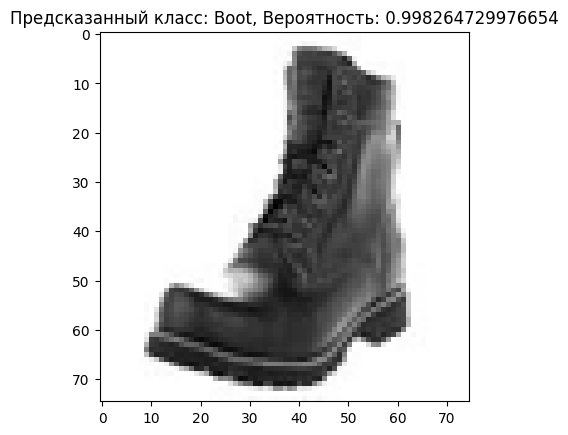

Предсказанный класс: Shoe
Истинный класс: Boot
Вероятность: 0.71085805


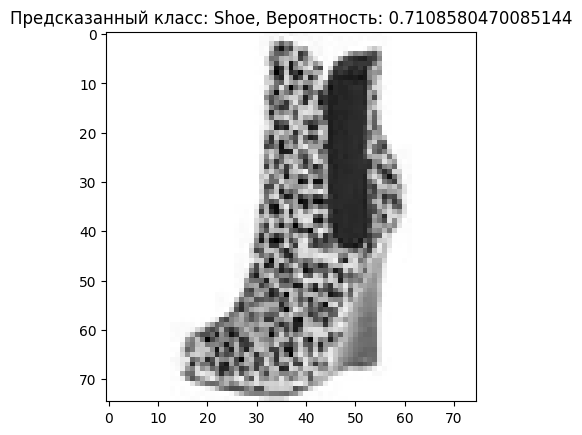

Предсказанный класс: Boot
Истинный класс: Boot
Вероятность: 0.9784


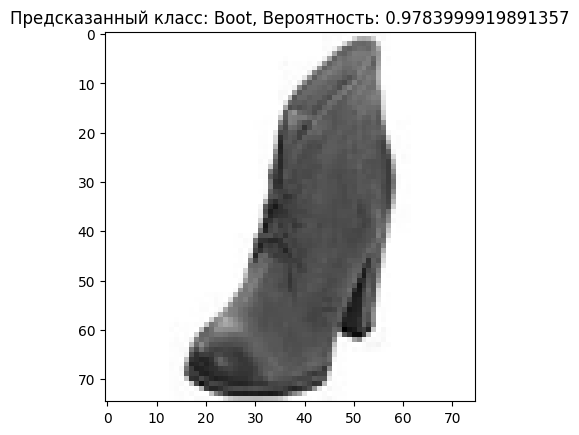

Предсказанный класс: Boot
Истинный класс: Boot
Вероятность: 0.99403346


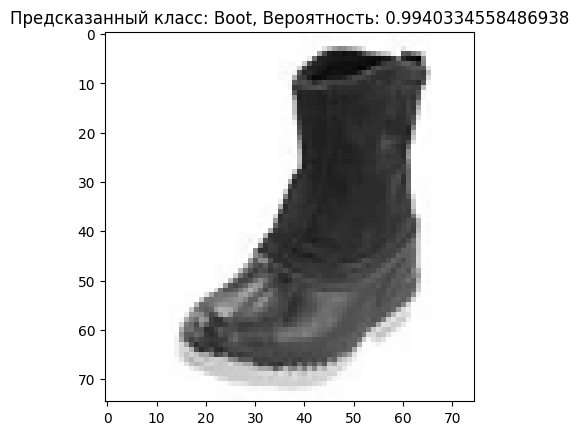

Предсказанный класс: Boot
Истинный класс: Boot
Вероятность: 0.9717086


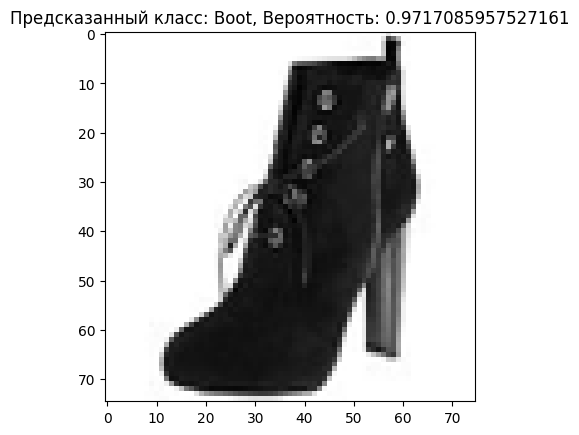

Предсказанный класс: Shoe
Истинный класс: Sandal
Вероятность: 0.68228805


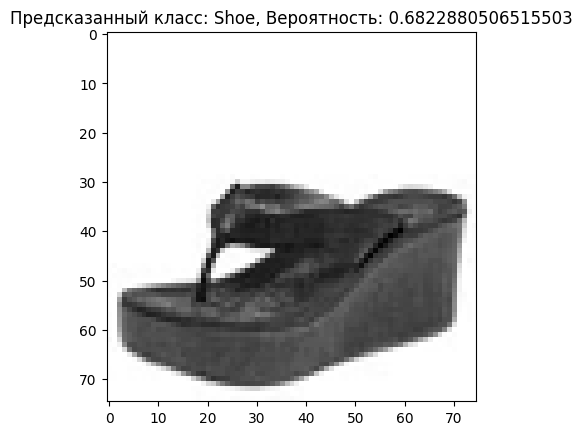

Предсказанный класс: Sandal
Истинный класс: Sandal
Вероятность: 0.56849825


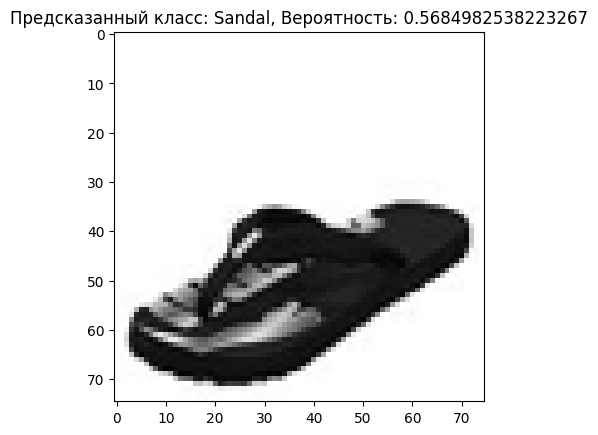

Предсказанный класс: Shoe
Истинный класс: Sandal
Вероятность: 0.78398937


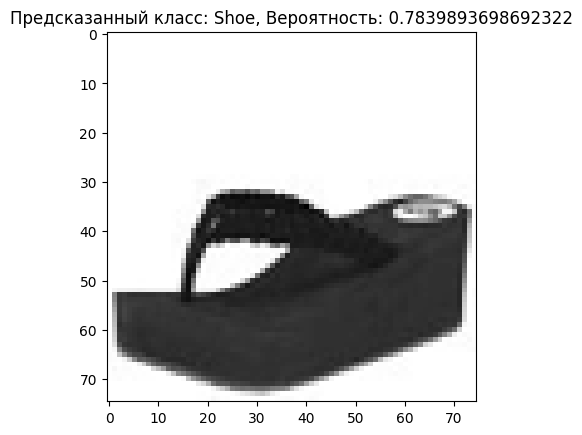

Предсказанный класс: Sandal
Истинный класс: Sandal
Вероятность: 0.69977915


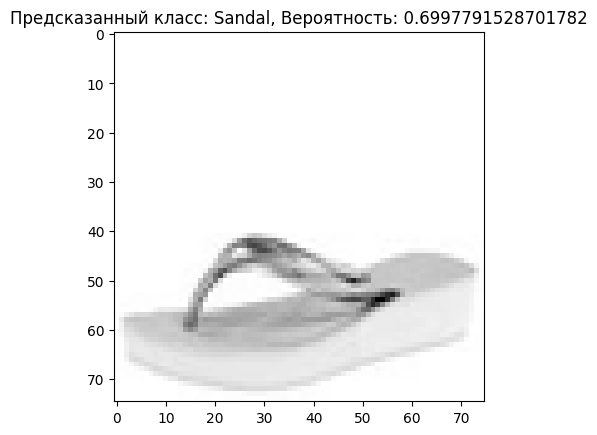

Предсказанный класс: Sandal
Истинный класс: Sandal
Вероятность: 0.9684721


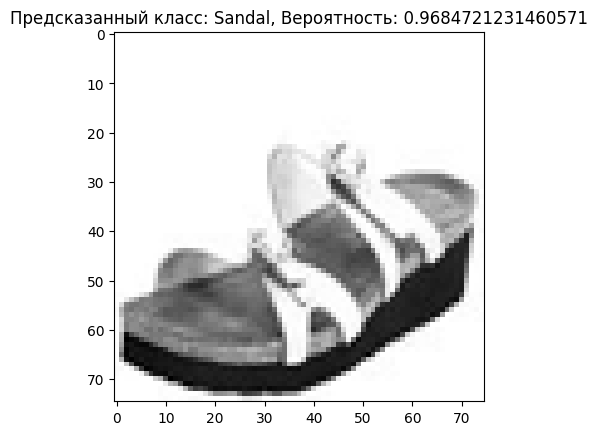

Предсказанный класс: Shoe
Истинный класс: Shoe
Вероятность: 0.84142476


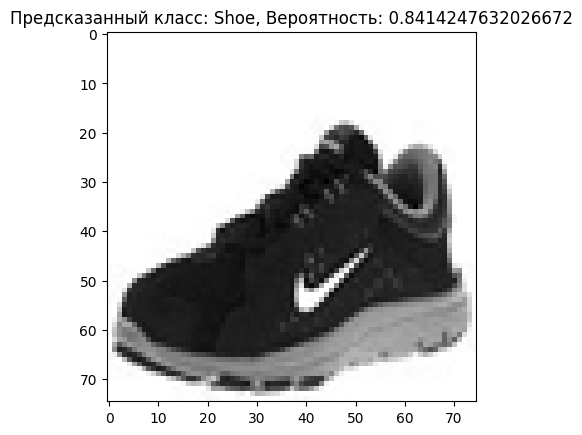

Предсказанный класс: Shoe
Истинный класс: Shoe
Вероятность: 0.56144917


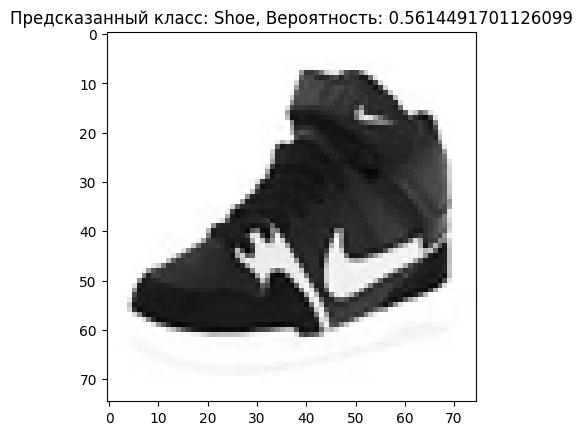

Предсказанный класс: Shoe
Истинный класс: Shoe
Вероятность: 0.9370146


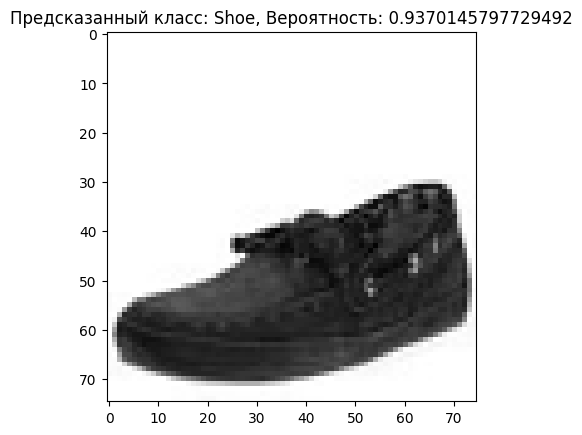

Предсказанный класс: Boot
Истинный класс: Shoe
Вероятность: 0.6309642


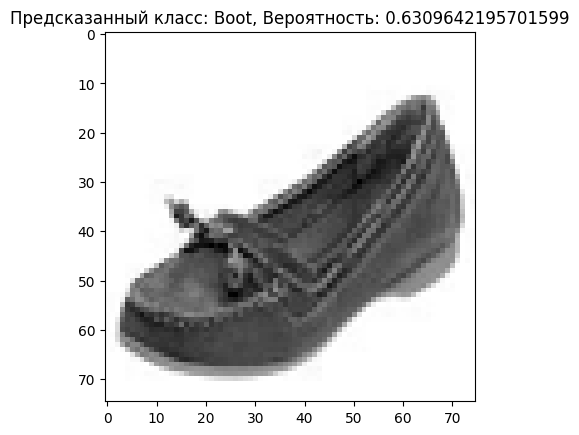

Предсказанный класс: Shoe
Истинный класс: Shoe
Вероятность: 0.7444173


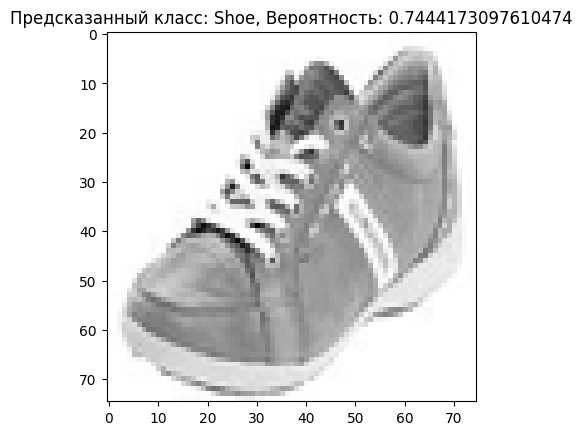

In [35]:
# Распечатываем предсказанные метки и вероятности для каждого изображения
for i in range(len(random_images)):
    predicted_label = encoder.classes_[np.argmax(
        predictions[i])]  # Получаем предсказанную метку
    probability = predictions[i][np.argmax(
        predictions[i])]  # Получаем вероятность этой метки
    true_label = random_labels[i]  # Получаем истинную метку
    print("Предсказанный класс:", predicted_label)
    print("Истинный класс:", true_label)
    print("Вероятность:", probability)
    plt.imshow(random_images[i], cmap='gray')
    plt.title(
        f"Предсказанный класс: {predicted_label}, Вероятность: {probability}")
    plt.show()